In [1]:
from functions import *

In [3]:
pip install sentinelhub

  Obtaining dependency information for sentinelhub from https://files.pythonhosted.org/packages/91/0c/c092d9f8ecfff2cf5fd003adc487eb4bd7244cc15146d5b925be9d8c52e4/sentinelhub-3.11.1-py3-none-any.whl.metadata
  Obtaining dependency information for aenum>=2.1.4 from https://files.pythonhosted.org/packages/d0/fa/ca0c66b388624ba9dbbf35aab3a9f326bfdf5e56a7237fe8f1b600da6864/aenum-3.1.15-py3-none-any.whl.metadata
  Obtaining dependency information for dataclasses-json from https://files.pythonhosted.org/packages/c3/be/d0d44e092656fe7a06b55e6103cbce807cdbdee17884a5367c68c9860853/dataclasses_json-0.6.7-py3-none-any.whl.metadata
  Obtaining dependency information for oauthlib from https://files.pythonhosted.org/packages/7e/80/cab10959dc1faead58dc8384a781dfbf93cb4d33d50988f7a69f1b7c9bbe/oauthlib-3.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for requests-oauthlib>=1.0.0 from https://files.pythonhosted.org/packages/3b/5d/63d4ae3b9daea098d5d6f5da83984853c1bbacd5dc826764b249fe11

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob
import time
from datetime import datetime
from collections import Counter
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from rasterio.windows import Window
from collections import Counter

## Load model

In [3]:
tf.get_logger().setLevel('ERROR') 
model_name = 'simple_CNN'
model = load_model(f'../models/{model_name}.h5')

## Load data

In [4]:
filt_alt = False 
W=64
split='random'
inputs=['lst','ndvi','slope','direction', 'altitude']
if W==128:
        data_folder = '../data/preprocessed/'
else:
    data_folder = f'../data/preprocessed_test/{W}x{W}/'
        
data = load_all_data(
source_folder='../data/external/shp/river_cells_oficial',
source_path=data_folder,
data_paths= inputs,
filter_altitude=filt_alt,
W=W,
time_split=True if split=='time' else False)

RasterioIOError: ../../../../../data/simon.walther/swissAltitude/swissAltitude.vrt: No such file or directory

In [ ]:
total_data, total_times, data_targets, labels = data
cosine_months, sine_months, cos_to_month = get_months_vectorized(total_times['lst'])
lat, lon = get_lat_lon(labels)
discharge = get_discharge(labels, total_times['lst'])
additional_inputs = np.column_stack((cosine_months, sine_months, lat, lon, discharge))

expanded_images = []
    
for inp in inputs:
    all_images = total_data[inp]  # Load all images for the current input
    mean_val = np.mean(all_images)  # Compute the mean
    std_val = np.std(all_images)  # Compute the standard deviation
    
    # Handle edge case: Avoid division by zero if std is zero
    if std_val == 0:
        print(f"Warning: Standard deviation for {inp} is zero. Skipping normalization.")
        normalized_images = all_images  # Leave unchanged
    else:
        normalized_images = (all_images - mean_val) / std_val  # Z-score normalization
    
    # Expand dimensions if necessary
    if normalized_images.ndim == 3:
        normalized_images = np.expand_dims(normalized_images, axis=-1)
    
    # Append normalized images
    expanded_images.append(normalized_images)

# Combine all normalized images
combined_input = np.concatenate(expanded_images, axis=-1)
input_data = combined_input
'''
global_ranges = {}
for inp in inputs:  
    all_images = total_data[inp]  
    global_min = np.min(all_images)
    global_max = np.max(all_images)
    global_ranges[inp] = (global_min, global_max)
    print(f"Variable: {inp}, Min: {global_min}, Max: {global_max}")

expanded_images = []
for inp in inputs:  
    all_images = total_data[inp]  
    min_val, max_val = global_ranges[inp]  
    normalized_images = normalize_min_max(all_images, min_val, max_val)
    if normalized_images.ndim == 3:  
        normalized_images = np.expand_dims(normalized_images, axis=-1)  
    expanded_images.append(normalized_images)
combined_input = np.concatenate(expanded_images, axis=-1)  
input_data = combined_input'''

train_index, validation_index, test_index = get_split_index('stratified', input_data, data_targets, labels, 1, filt_alt)
validation_input = input_data[validation_index, :] 
validation_target = data_targets[validation_index]
test_input = input_data[test_index, :]
test_target = data_targets[test_index]
train_input = input_data[train_index, :]
train_target = data_targets[train_index]

additional_inputs_train = additional_inputs[train_index, :]
additional_inputs_validation = additional_inputs[validation_index, :]
additional_inputs_test = additional_inputs[test_index, :]


## Load rivers

In [ ]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass

# Gradients on test set

In [ ]:
test_inp_labels={}
test_dates = {}
test_additional_inp = {}
test_dates_array = np.array(total_times['lst'])[test_index]

for i,l in enumerate(np.array(labels)[test_index]):
    if l not in test_inp_labels:
        test_inp_labels[l] = [test_input[i]]
        test_dates[l] = [test_dates_array[i]]
        test_additional_inp[l] = [additional_inputs_test[i]]
    else:
        test_inp_labels[l].append(test_input[i])
        test_dates[l].append(test_dates_array[i])
        test_additional_inp[l].append(additional_inputs_test[i])
        


In [ ]:
imgs = Counter(list(np.array(labels)[test_index]))
len(test_dates)

## Create gradients images

In [10]:
for cell, test_images in test_inp_labels.items():
    for i,test_image in enumerate(test_images):
        test_image_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
        test_image_tensor = tf.expand_dims(test_image_tensor, axis=0)
        add_input = tf.convert_to_tensor(test_additional_inp[cell][i], dtype=tf.float32)
        add_input = tf.expand_dims(add_input, axis=0)
        
        # Use GradientTape to track gradients
        with tf.GradientTape() as tape:
            tape.watch(test_image_tensor)  # Watch the tensor
            preds = model([test_image_tensor,add_input], training=False)  # Perform prediction
            target_output = preds[:, 0]  # Assuming target_output is scalar, adjust as needed
        
        # Calculate the gradients
        gradients = tape.gradient(target_output, test_image_tensor)
        
        folder_path = f'../plots/grad_cam/{model_name}/{cell}'
        os.makedirs(folder_path,exist_ok=True)
        clear_directory(folder_path)
        date = test_dates[cell][i]
        image_path = os.path.join(folder_path, f'image_{date}')
        impact_channel = 3
        save_grad_map(gradients, image_path, impact_channel, W, save_numpy=True)

2024-11-27 15:30:16.276043: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1732717816.389311 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.430057 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.430829 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.432129 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.432800 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.433465 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.434117 1560704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732717816.434804 1560704 gpu_t

Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2013-10
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2014-09
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2021-09
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2015-04
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2024-05
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2013-08
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2017-06
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2021-08
Saved at ../plots/grad_cam/baseline_CNN/cell_76/image_2018-02
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2013-10
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2014-11
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2023-06
Saved at ../plots/grad_cam/baseline_CNN/cell_72/image_2024-07
Saved at ../plots/grad_cam/baseline_CNN/cell_22/image_2013-09
Saved at ../plots/grad_cam/baseline_CNN/cell_22/image_2017-10
Saved at ../plots/grad_cam/baseline_CNN/cell_22/image_2020-11
Saved at

## Check predicted values

In [ ]:
test_input.shape

In [ ]:
if model_name == 'simple_CNN':
    y_pred = model.predict(test_input[...,0])
else:
    y_pred = model.predict([test_input,additional_inputs_test])

In [ ]:
y_test = np.array(test_target).flatten()
y_pred = np.array(y_pred).flatten()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (MSE): {rmse}")

In [ ]:
data = pd.DataFrame({"Date": list(np.array(total_times['lst'])[test_index]), 
                     "True": y_test, 
                     "Predicted": y_pred})

data["Date"] = pd.to_datetime(data["Date"].apply(str), format="%Y-%m")
data = data.sort_values("Date")

np.random.seed(0)  # For reproducibility

# Compute RMSE for each date
data["Error"] = (data["True"] - data["Predicted"])**2
data["RMSE"] = np.sqrt(data["Error"])

# Show dates with the largest RMSE
largest_rmse = data.nlargest(10, "RMSE")

# Plot True vs Predicted values
plt.figure(figsize=(15, 6))
plt.plot(data["Date"], data["True"], label="True Values", marker="o", linestyle="--")
plt.plot(data["Date"], data["Predicted"], label="Predictions", marker="x", linestyle="-")
plt.xlabel("Date")
plt.ylabel("Water Temperature")
plt.title("Comparison of True Values and Predictions by Month")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
largest_rmse


(array([11., 23., 57., 67., 24., 23., 27., 14., 11.,  5.]),
 array([ 0.23 ,  2.555,  4.88 ,  7.205,  9.53 , 11.855, 14.18 , 16.505,
        18.83 , 21.155, 23.48 ]),
 <BarContainer object of 10 artists>)

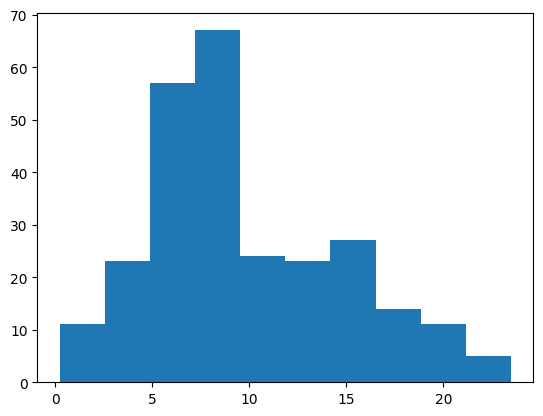

In [13]:
plt.hist(data["True"])

## Post processing step

In [29]:
additional_inputs.shape

(1378, 5)

Ejemplo de outlier_dict: [((8, (2501212.0, 1115123.0), 12.22), False), ((2, (2501212.0, 1115123.0), 5.91), False), ((5, (2501212.0, 1115123.0), 10.48), False), ((6, (2501212.0, 1115123.0), 11.84), False), ((11, (2501212.0, 1115123.0), 7.41), False)]


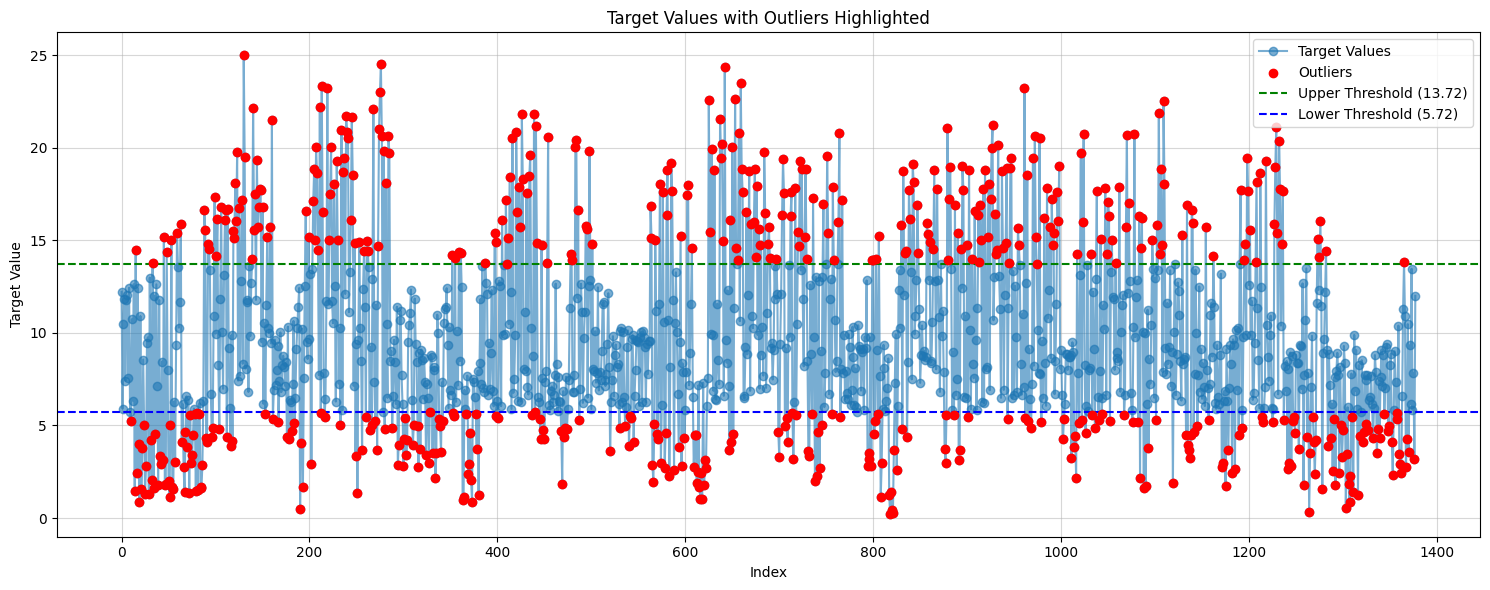

In [36]:
import pickle
mean_target = np.mean(data_targets)
threshold = 4.0  

# Identify indices of outliers
outlier_indices = np.where(np.abs(data_targets - mean_target) > threshold)[0]

# Create a mask for outlier images
outlier_mask = np.zeros(len(data_targets), dtype=bool)

var_channels = {'lst': 0, 'ndvi': 1, 'slope': 2, 'altitude': 3, 'direction': 4}
var_position = {'month': [0, 1], 'coords': [2, 3], 'discharge': 4}
with open('../data/external/cos_to_month.pkl', 'rb') as file:
    cos_to_month = pickle.load(file)
    
months = [cos_to_month[val] for val in additional_inputs[..., var_position['month'][0]]]
coords = additional_inputs[..., var_position['coords']]

outlier_dict = {}

# Iterar sobre todos los índices de data_targets
for i in range(len(data_targets)):
    # Crear la clave para cada elemento
    key = (months[i], tuple(coords[i]), data_targets[i])

    # Verificar si el índice está en outlier_indices
    is_outlier = i in outlier_indices

    # Asignar el valor al diccionario
    outlier_dict[key] = is_outlier

# Imprimir un ejemplo del diccionario
print("Ejemplo de outlier_dict:", list(outlier_dict.items())[:5])
outlier_dict_serialized = {str(key): value for key, value in outlier_dict.items()}

# Guardar en un archivo JSON
with open('../data/external/outlier_dict.json', 'w') as json_file:
    json.dump(outlier_dict_serialized, json_file, indent=4)


outlier_mask[outlier_indices] = True


# Plot the target values with outliers highlighted
plt.figure(figsize=(15, 6))
plt.plot(range(len(data_targets)), data_targets, label='Target Values', marker='o', linestyle='-', alpha=0.6)
plt.scatter(outlier_indices, data_targets[outlier_indices], color='red', label='Outliers', zorder=5)
plt.axhline(mean_target + threshold, color='green', linestyle='--', label=f'Upper Threshold ({mean_target + threshold:.2f})')
plt.axhline(mean_target - threshold, color='blue', linestyle='--', label=f'Lower Threshold ({mean_target - threshold:.2f})')

plt.title('Target Values with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('../plots/outlier_target_values.png')
plt.show()


In [ ]:
np.save("../data/external/outliers_mask.npy", outlier_mask)

In [8]:
outs=np.load('../data/external/outliers_mask.npy')
print(len(outs[outs==True]))
print(len(outs[outs==False]))

626
752


## Analyse gradients

#### Load and crop rasters

../data/external/raster_masks/raster_mask_bw_cell_31.tif
(128, 128)
(64, 64)


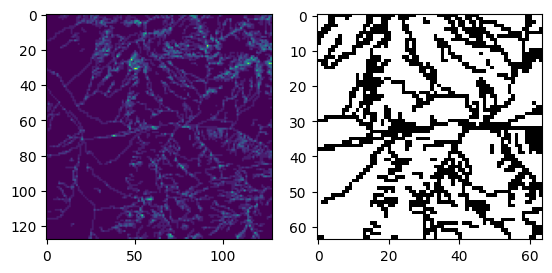

../data/external/raster_masks/raster_mask_bw_cell_71.tif
(128, 128)
(64, 64)


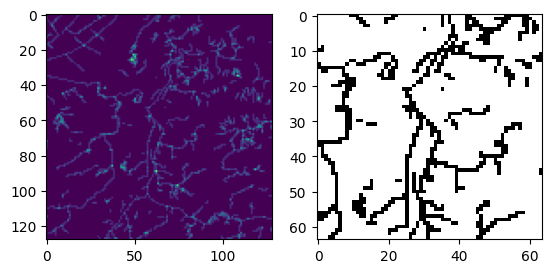

../data/external/raster_masks/raster_mask_bw_cell_60.tif
(128, 128)
(64, 64)


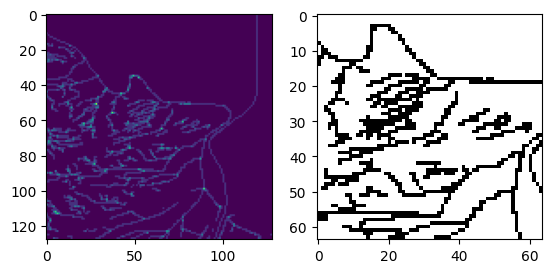

../data/external/raster_masks/raster_mask_bw_cell_32.tif
(128, 128)
(64, 64)


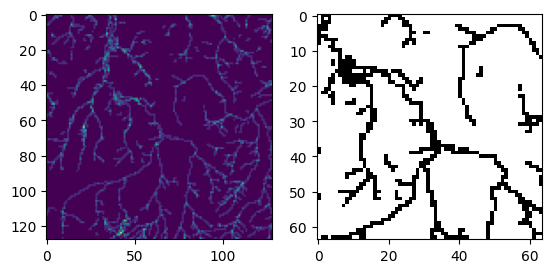

../data/external/raster_masks/raster_mask_bw_cell_1.tif
(128, 128)
(64, 64)


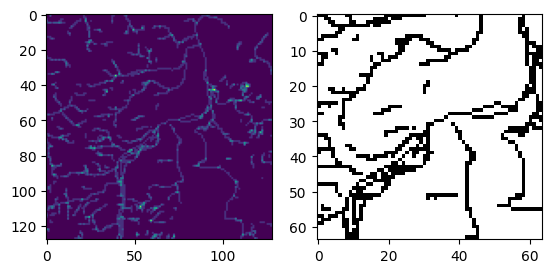

../data/external/raster_masks/raster_mask_bw_cell_77.tif
(128, 128)
(64, 64)


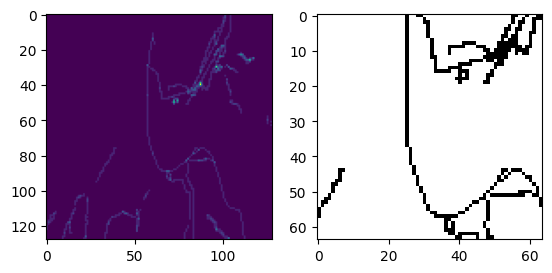

../data/external/raster_masks/raster_mask_bw_cell_45.tif
(128, 128)
(64, 64)


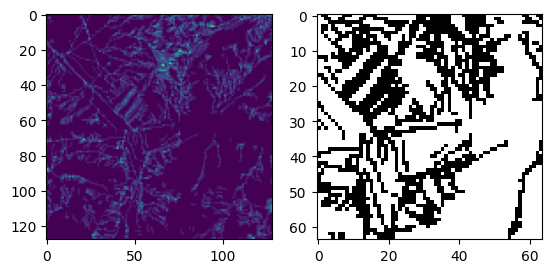

../data/external/raster_masks/raster_mask_bw_cell_74.tif
(128, 128)
(64, 64)


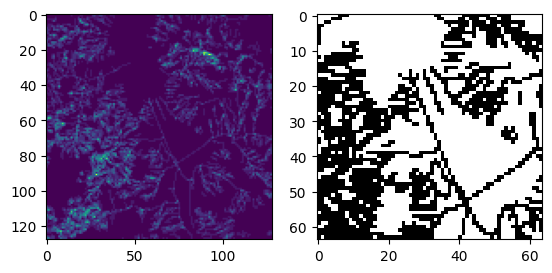

../data/external/raster_masks/raster_mask_bw_cell_35.tif
(128, 128)
(64, 64)


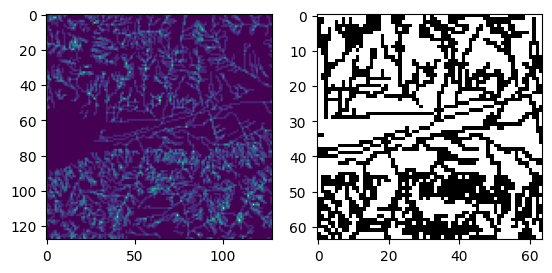

../data/external/raster_masks/raster_mask_bw_cell_25.tif
(128, 128)
(64, 64)


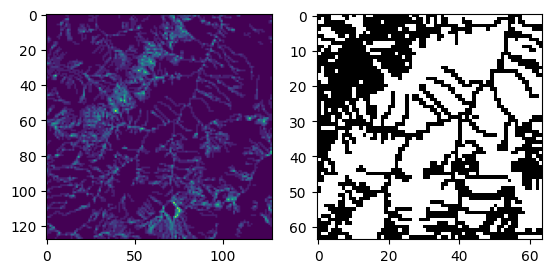

../data/external/raster_masks/raster_mask_bw_cell_2.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_64.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_21.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_51.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_49.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_12.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_58.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_46.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_53.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_40.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_55.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_5.tif
(128, 128)
(64, 64)
../data/external/raster_masks/raster_mask_bw_cell_39.tif
(128, 128)
(64, 64)
.

In [11]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_cut = {}
c=0
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    print(raster_path)
    river_masks[cc]=rast
    print(rast.shape)
    rast_cut = crop_raster(raster_path, W)
    print(rast_cut.shape)
    binary_image = (rast_cut == 0).astype(float)
    river_masks_cut[cc]=binary_image
    if c <10:
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(rast)
        ax[1].imshow(binary_image, cmap="gray", interpolation="nearest")
        plt.show()
    c+=1
    

In [22]:
print(f"Shape of grad_combined: {grad_combined.shape}")
print(f"Shape of expanded_mask: {expanded_mask.shape}")


Shape of grad_combined: (3, 64)
Shape of expanded_mask: (64, 64)


In [24]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

grad_maps = {
    "LST": {},
    "NDVI": {},
    "Slope": {},
    "Direction": {},
    "Altitude": {},
}

# Dictionaries to store general and river-specific impacts
variable_impact_general = {
    "LST": {},
    "NDVI": {},
    "Slope": {},
    "Direction": {},
    "Altitude": {},
}

variable_impact_river = {
    "LST": {},
    "NDVI": {},
    "Slope": {},
    "Direction": {},
    "Altitude": {},
}

cell_grad_analysis = {}
river_grad_analysis = {}

for cell, test_images in test_inp_labels.items():
    cell_grad_analysis[cell] = {}
    river_grad_analysis[cell] = {}
    river_mask = river_masks_cut[cell]  # Binary raster (0: outside river, 1: inside river)
    for i, test_image in enumerate(test_images):
        # Expand the mask to include contiguous pixels
        expanded_mask = np.pad(river_mask, pad_width=1, mode='constant')
        expanded_mask = (
            np.maximum(expanded_mask[:-2, :-2], expanded_mask[1:-1, :-2])
            + np.maximum(expanded_mask[:-2, 1:-1], expanded_mask[1:-1, 1:-1])
            + np.maximum(expanded_mask[:-2, 2:], expanded_mask[1:-1, 2:])
        ) >= 1  # Expand to include neighboring pixels

        # Convert the image and additional inputs to tensors
        test_image_tensor = tf.convert_to_tensor(test_image, dtype=tf.float32)
        test_image_tensor = tf.expand_dims(test_image_tensor, axis=0)  # Add batch dimension

        add_input = tf.convert_to_tensor(test_additional_inp[cell][i], dtype=tf.float32)
        add_input = tf.expand_dims(add_input, axis=0)

        # Use GradientTape to calculate gradients
        with tf.GradientTape() as tape:
            tape.watch(test_image_tensor)
            preds = model([test_image_tensor, add_input], training=False)  # Perform prediction
            target_output = preds[:, 0]  # Assume scalar output

        # Compute gradients with respect to the image
        gradients = tape.gradient(target_output, test_image_tensor)#.numpy()

        # Compute general and river-specific impacts
        for variable, channels in {
            "LST": range(3),
            "NDVI": [3],
            "Slope": [4],
            "Direction": [5],
            "Altitude": [6],
        }.items():
            # Combine gradients for the variable
            grads_map = gradients[0, :, :, channels].numpy()
            if cell not in grad_maps[variable]:
                grad_maps[variable][cell] = [grads_map]
            else:
                grad_maps[variable][cell].append(grads_map)

    for variable, channels in {
            "LST": range(3),
            "NDVI": [3],
            "Slope": [4],
            "Direction": [5],
            "Altitude": [6],
        }.items():
        grad_images = np.array(grad_maps[variable][cell])
        mean_grad = np.mean(grad_images, axis=0)
        
        general_impact = np.mean(np.abs(mean_grad))  # Mean magnitude
        general_direction = np.mean(np.sign(mean_grad))

        river_impact = np.mean(np.abs(mean_grad[expanded_mask]))
        river_direction = np.mean(np.sign(mean_grad[expanded_mask]))

        if cell not in grad_maps[variable]:
            variable_impact_general[variable][cell] = [(general_impact,general_direction)]
            variable_impact_river[variable][cell] = [(river_impact,river_direction)]

        else:
            variable_impact_general[variable][cell].append((general_impact,general_direction))
            variable_impact_river[variable][cell].append((river_impact,river_direction))

        influence = "increases" if general_direction > 0 else "decreases"
        cell_grad_analysis[cell][variable]={'magnitude':general_impact, 'direction':general_direction}
        river_grad_analysis[cell][variable]={'magnitude':river_impact, 'direction':river_direction}
        
    


        '''
            grad_images = np.array(grads_map)
            mean_grad = np.mean(grad_images, axis=0)
            mean_magnitude = np.mean(np.abs(mean_grad))  # Mean magnitude
            mean_direction = np.mean(np.sign(mean_grad))
            
            grad_combined = np.mean(np.abs(gradients[0, :, :, channels]), axis=-1).mean(axis=0)
            print(f"Shape of grad_combined: {grad_combined.shape}")  # Should be (64, 64)
            print(f"Shape of expanded_mask: {expanded_mask.shape}")

            # General impact
            general_impact = np.mean(grad_combined)
            variable_impact_general[variable].append(general_impact)

            # River-specific impact
            river_impact = np.mean(grad_combined[expanded_mask])
            variable_impact_river[variable].append(river_impact)

        # Save heatmaps (optional)
        folder_path = f'../plots/grad_cam/{model_name}/{cell}'
        os.makedirs(folder_path, exist_ok=True)
        date = test_dates[cell][i]

        # Save general heatmaps
        for variable, channels in {
            "Variable 1 (Channels 0-2)": range(3),
            "Channel 3": [3],
            "Channel 4": [4],
            "Channel 5": [5],
            "Channel 6": [6],
        }.items():
            grad_combined = np.mean(np.abs(gradients[0, :, :, channels]), axis=-1)
            plt.imshow(grad_combined, cmap="jet")
            plt.colorbar()
            plt.title(f"{variable} General Impact")
            plt.savefig(os.path.join(folder_path, f'image_{date}_{variable.replace(" ", "_")}_general.png'), dpi=300, bbox_inches="tight")
            plt.close()

            # Save river-specific heatmaps
            grad_river = np.where(expanded_mask, grad_combined, 0)  # Apply mask
            plt.imshow(grad_river, cmap="jet")
            plt.colorbar()
            plt.title(f"{variable} River-Specific Impact")
            plt.savefig(os.path.join(folder_path, f'image_{date}_{variable.replace(" ", "_")}_river.png'), dpi=300, bbox_inches="tight")
            plt.close()'''
'''
# Compare the impact of the variables
average_impact_general = {var: np.mean(impacts) for var, impacts in variable_impact_general.items()}
average_impact_river = {var: np.mean(impacts) for var, impacts in variable_impact_river.items()}

# Display general and river-specific impacts
print("General Variable Impact Sorted by Importance:")
for variable, impact in sorted(average_impact_general.items(), key=lambda x: x[1], reverse=True):
    print(f"{variable}: Average General Impact = {impact}")

print("\nRiver-Specific Variable Impact Sorted by Importance:")
for variable, impact in sorted(average_impact_river.items(), key=lambda x: x[1], reverse=True):
    print(f"{variable}: Average River Impact = {impact}")'''


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got range(0, 3)

#### Compute mean magnitude and influence 

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Folder containing gradient data
grad_folder = f'../plots/grad_cam/{model_name}'
c = 0
W = 64  # Expected size for resized images
cell_grad_analysis = {}

for cell in test_inp_labels.keys():
    cell_grad_folder = os.path.join(grad_folder, cell)
    grad_images = []
    norm_grad_images = []

    for grad_file_name in os.listdir(cell_grad_folder):
        grad_file_path = os.path.join(cell_grad_folder, grad_file_name)

        # Handle unnormalized gradients from .npy
        if grad_file_name.endswith('.npy'):
            try:
                grad_array = np.load(grad_file_path)  # Load unnormalized gradients
                
                # Resize if necessary
                if grad_array.shape != (W, W):  # Resize if sizes do not match
                    grad_array = tf.image.resize(grad_array[..., np.newaxis], (W, W)).numpy().squeeze()
                
                grad_images.append(grad_array)
            except Exception as e:
                print(f"Error loading {grad_file_name}: {e}")
                continue

    # Skip the cell if no gradients are available
    if not grad_images:
        print(f"Cell {cell} has no gradient data. Skipping...")
        continue

    # Convert gradient arrays to NumPy and calculate the mean for unnormalized gradients
    grad_images = np.array(grad_images)
    mean_grad = np.mean(grad_images, axis=0)  # Mean of unnormalized gradients for the cell

    # Handle NaN or invalid shapes
    if np.isnan(mean_grad).any() or mean_grad.size == 0:
        print(f"Cell {cell} produced invalid gradients. Skipping...")
        continue

    # Calculate the mean magnitude and direction of the gradients
    mean_magnitude = np.mean(np.abs(mean_grad))  # Mean magnitude
    mean_direction = np.mean(np.sign(mean_grad))  # Mean direction (+1, 0, -1)
    influence = "increases" if mean_direction > 0 else "decreases"

    cell_grad_analysis[cell]={'magnitude':mean_magnitude, 'direction':mean_direction}
    

    print(f"Cell: {cell}, Mean Magnitude: {mean_magnitude:.4f}, Impact: {influence}")

    # Visualization for the first 10 cells
    if c < 10:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Display the mean unnormalized gradient
        im = ax[0].imshow(mean_grad, cmap="bwr")
        fig.colorbar(im, ax=ax[0])
        ax[0].set_title("Mean Gradients (Unnormalized)")

        # Display the river mask
        ax[1].imshow(river_masks_cut[cell], cmap="gray", interpolation="nearest")
        ax[1].set_title("River Image")

        plt.tight_layout()
        plt.show()

    c += 1


#### Analyse results and identify high influence locations

In [ ]:
import numpy as np

# Separate cells into "increase" and "decrease" based on direction
increase_cells = {cell: data for cell, data in cell_grad_analysis.items() if data["direction"] > 0}
decrease_cells = {cell: data for cell, data in cell_grad_analysis.items() if data["direction"] < 0}

# Extract magnitudes for each group
increase_magnitudes = [data["magnitude"] for data in increase_cells.values()]
decrease_magnitudes = [data["magnitude"] for data in decrease_cells.values()]

# Calculate statistics for each group
increase_mean = np.mean(increase_magnitudes)
increase_std = np.std(increase_magnitudes)
increase_threshold = increase_mean + increase_std  # Threshold for "large" influence

decrease_mean = np.mean(decrease_magnitudes)
decrease_std = np.std(decrease_magnitudes)
decrease_threshold = decrease_mean + decrease_std  # Threshold for "large" influence

# Identify cells with large influence in each group
large_increase_cells = {cell: data["magnitude"] for cell, data in increase_cells.items() if data["magnitude"] > increase_threshold}
large_decrease_cells = {cell: data["magnitude"] for cell, data in decrease_cells.items() if data["magnitude"] > decrease_threshold}

# Output results
print("Increase Cells:")
print(f"  Mean Magnitude: {increase_mean:.4f}, Std: {increase_std:.4f}, Large Threshold: {increase_threshold:.4f}")
print("  Large Influence:")
for cell, mag in large_increase_cells.items():
    print(f"    {cell}: {mag:.4f}")

print("\nDecrease Cells:")
print(f"  Mean Magnitude: {decrease_mean:.4f}, Std: {decrease_std:.4f}, Large Threshold: {decrease_threshold:.4f}")
print("  Large Influence:")
for cell, mag in large_decrease_cells.items():
    print(f"    {cell}: {mag:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Plot Increase Magnitudes
plt.figure(figsize=(8, 5))
plt.bar(increase_cells.keys(), increase_magnitudes, color="blue", label="Increase")
plt.axhline(y=increase_mean, color="r", linestyle="--", label="Mean Magnitude")
plt.axhline(y=increase_threshold, color="g", linestyle="--", label="Large Threshold")
plt.title("Gradient Magnitudes for Increase Cells")
plt.xlabel("Cells")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

# Plot Decrease Magnitudes
plt.figure(figsize=(8, 5))
plt.bar(decrease_cells.keys(), decrease_magnitudes, color="orange", label="Decrease")
plt.axhline(y=decrease_mean, color="r", linestyle="--", label="Mean Magnitude")
plt.axhline(y=decrease_threshold, color="g", linestyle="--", label="Large Threshold")
plt.title("Gradient Magnitudes for Decrease Cells")
plt.xlabel("Cells")
plt.ylabel("Magnitude")
plt.legend()
plt.show()
